In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString
import os
from fbprophet import Prophet

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
files = [i for i in os.listdir('../data/VT_deer/') if '_deer_Crash' in i]

In [3]:
basepath = '../data/VT_deer/'

In [4]:
df = pd.read_csv(basepath+files[0])

In [5]:
df_list = list()
for f in files:
    fpath = basepath + f
    df_list.append(pd.read_csv(fpath))
df = pd.concat(df_list, ignore_index=True)

```python
df.to_csv("vt_deer_collisions_2010_2019_190919.csv")
```

In [6]:
df.shape

(2590, 27)

In [7]:
df["Crash Date"] = pd.to_datetime(df["Crash Date"])
df.sort_values("Crash Date", inplace=True)
df["time"] = df["Crash Date"].dt.time
df["dayofweek"] = df["Crash Date"].dt.day_name()

In [8]:
df["Crash Date"].tail().dt.time

946    17:31:00
947    16:43:00
948    20:12:00
949    10:07:00
950    16:31:00
Name: Crash Date, dtype: object

## Standard times
From row 0:247
- could resample from later dates to estimate times.

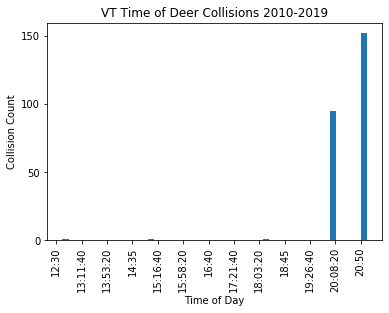

In [12]:
plt.hist(df.iloc[:250,:].time, bins=50)

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=14)
plt.xticks(rotation=90)
plt.xlabel('Time of Day')
plt.ylabel('Collision Count')
plt.title('VT Time of Deer Collisions 2010-2019')
#plt.savefig('vt_time_of_collisions_190918.svg')
None

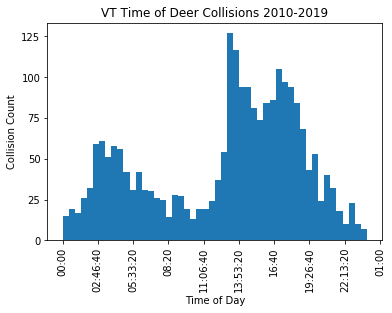

In [119]:
hist = plt.hist(df.iloc[250:,:].time, bins=50)

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=14)
plt.xticks(rotation=90)
plt.xlabel('Time of Day')
plt.ylabel('Collision Count')
plt.title('VT Time of Deer Collisions 2010-2019')
#plt.savefig('vt_time_of_collisions_190918.svg')
None

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  after removing the cwd from sys.path.


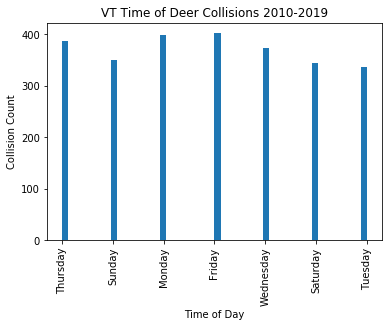

In [14]:
plt.hist(df.dayofweek, bins=50)

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=14)
plt.xticks(rotation=90)
plt.xlabel('Time of Day')
plt.ylabel('Collision Count')
plt.title('VT Time of Deer Collisions 2010-2019')
#plt.savefig('vt_time_of_collisions_190918.svg')
None

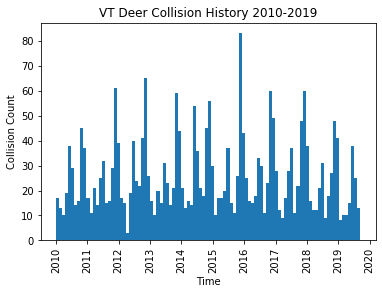

In [15]:
plt.hist(df["Crash Date"], bins=100)

#plt.locator_params(axis='y', nbins=6)
#plt.locator_params(axis='x', nbins=15)
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Collision Count')
plt.title('VT Deer Collision History 2010-2019')
#plt.savefig('vt_collisions_over_time_190918.svg')
None

In [16]:
test = df.copy()
test.index = test["Crash Date"]
monthly_full = test.groupby(pd.Grouper(freq='M')).count().ObjectID
monthly_full = monthly_full.reset_index()
monthly_full.columns = ['ds', 'y']

In [17]:
test.index = test.index.map(lambda dt: dt.replace(year=2019, month=1, day=1))
hourly = test.iloc[250:,:].groupby(pd.Grouper(freq='H')).count().ObjectID
hourly = hourly.reset_index()
hourly.columns = ['ds', 'y']

# Hourly frequency model
I could fit a couple guassians to that profile.

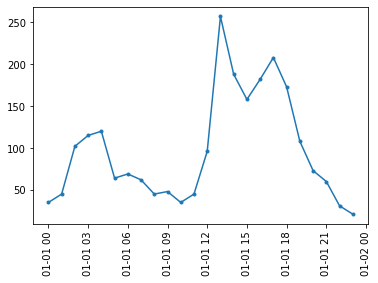

In [18]:
plt.plot(hourly.ds, hourly.y, marker='.')
plt.xticks(rotation=90)
None

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

#data = np.genfromtxt('data.txt')

def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset

def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) +
        gaussian(x, h3, c3, w3, offset=0) + offset)

def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return three_gaussians(x, h1, c1, w1, h2, c2, w2, 0,0,1, offset)

errfunc3 = lambda p, x, y: (three_gaussians(x, *p) - y)**2
errfunc2 = lambda p, x, y: (two_gaussians(x, *p) - y)**2

In [120]:
y, x = hist[0], hist[1][1:]
y /= y.max()
guess3 = [60, 17.5e3, 10e3, 120, 50e3, 5e3, 100, 65e3, 10e3, 0]  # I guess there are 3 peaks, 2 are clear, but between them there seems to be another one, based on the change in slope smoothness there
guess2 = [60, 17.5e3, 10e3, 100, 60e3, 20e3, 0]  # I removed the peak I'm not too sure about
optim3, success3 = optimize.leastsq(errfunc3, guess3[:], args=(x, y))
optim2, success2 = optimize.leastsq(errfunc2, guess2[:], args=(x, y))
optim3

array([3.32398040e-01, 1.46998346e+04, 5.49206304e+03, 7.06000543e-01,
       4.94612344e+04, 2.23484799e+03, 6.28245838e-01, 6.14473945e+04,
       7.46462554e+03, 1.34156912e-01])

In [121]:
x

array([ 1725.6,  3451.2,  5176.8,  6902.4,  8628. , 10353.6, 12079.2,
       13804.8, 15530.4, 17256. , 18981.6, 20707.2, 22432.8, 24158.4,
       25884. , 27609.6, 29335.2, 31060.8, 32786.4, 34512. , 36237.6,
       37963.2, 39688.8, 41414.4, 43140. , 44865.6, 46591.2, 48316.8,
       50042.4, 51768. , 53493.6, 55219.2, 56944.8, 58670.4, 60396. ,
       62121.6, 63847.2, 65572.8, 67298.4, 69024. , 70749.6, 72475.2,
       74200.8, 75926.4, 77652. , 79377.6, 81103.2, 82828.8, 84554.4,
       86280. ])

In [231]:
pd.to_datetime(15000, unit='s')

Timestamp('1970-01-01 04:10:00')

In [115]:
pd.Timestamp(year=2019, month=1, day=1) + pd.Timedelta(11.5*60*60, 's')

Timestamp('2019-01-01 11:30:00')

In [128]:
(1825/100)*60*60

65700.0

In [ ]:
2400

In [94]:
with open('prophet_models/hourly_gaussian_numpy.txt', 'w') as f:
    np.savetxt(f, optim3)

In [210]:
time_query = 16.9*60*60

In [211]:
time_prob = three_gaussians(time_query, *optim3)

In [212]:
time_prob

0.7603280289877509

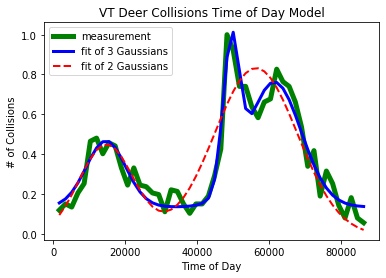

In [122]:
plt.plot(x, y, lw=5, c='g', label='measurement')
plt.plot(x, three_gaussians(x, *optim3),
    lw=3, c='b', label='fit of 3 Gaussians')
plt.plot(x, two_gaussians(x, *optim2),
    lw=2, c='r', ls='--', label='fit of 2 Gaussians')
plt.legend(loc='best')
plt.xlabel('Time of Day')
plt.ylabel('# of Collisions')
plt.title('VT Deer Collisions Time of Day Model')
#plt.savefig('vt_time_of_day_collision_model_190919.svg')
None

# Facebook Prophet modeling

## Finding the right time interval to pool collision data

### Group collisions by day

In [59]:
test = df.copy()
test.index = test["Crash Date"]
daily_full = test.groupby(pd.Grouper(freq='D')).count().ObjectID
daily_full = daily_full.reset_index()
daily_full.columns = ['ds', 'y']

In [60]:
daily_prophet = Prophet(seasonality_mode='multiplicative', mcmc_samples=300)
daily_prophet.fit(daily_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [73]:
daily_future = daily_prophet.make_future_dataframe(periods=52*3, freq='W')
daily_forecast = daily_prophet.predict(daily_future)

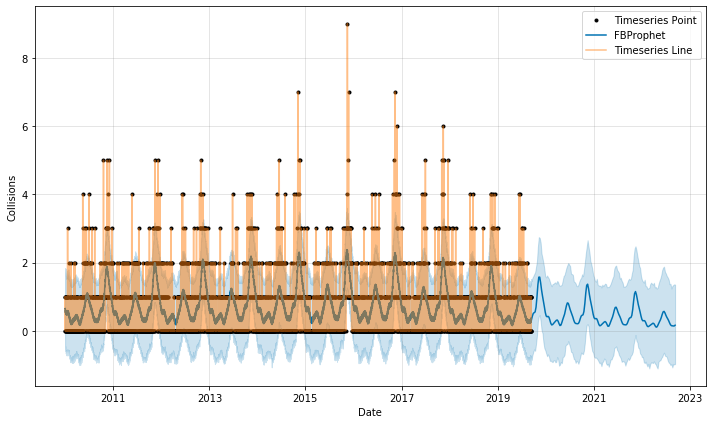

In [74]:
fig1 = daily_prophet.plot(daily_forecast, xlabel='Date', ylabel='Collisions')
x = daily_full.ds
y = daily_full.y
plt.plot(x, y, color='C1', alpha=.5)
plt.legend(['Timeseries Point', 'FBProphet', 'Timeseries Line'])
#plt.ylim(0, 120)
None

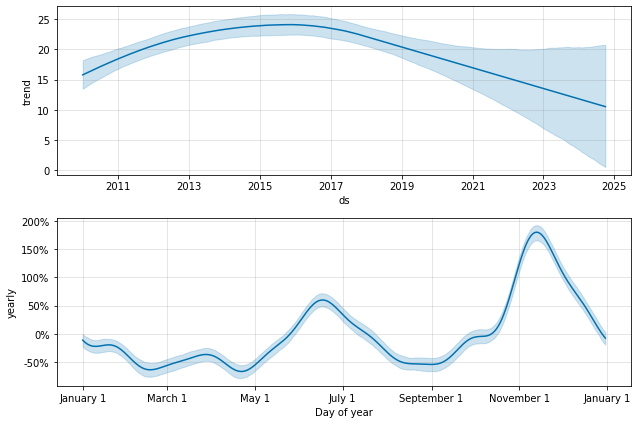

In [75]:
fig2 = daily_prophet.plot_components(forecast)

### Group collisions by week
**I like the daily prediction component in this model.**

In [53]:
test = df.copy()
test.index = test["Crash Date"]
weekly_full = test.groupby(pd.Grouper(freq='W')).count().ObjectID
weekly_full = weekly_full.reset_index()
weekly_full.columns = ['ds', 'y']

In [54]:
weekly_prophet = Prophet(seasonality_mode='multiplicative', mcmc_samples=300)
weekly_prophet.fit(weekly_full)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


I'm forecasting on a monthly basis. I'm not sure what happens if I drop this down to week. I'm thinking I'll have the same uncertainty issue that I'm having below when pooling the data by month and predicting by month. In that case the prediction is well-defined at the beginning of the month but uncertainty is large in the middle because there are no data point specified there.

In [67]:
weekly_future = weekly_prophet.make_future_dataframe(periods=52*2, freq='W')
weekly_forecast = weekly_prophet.predict(weekly_future)

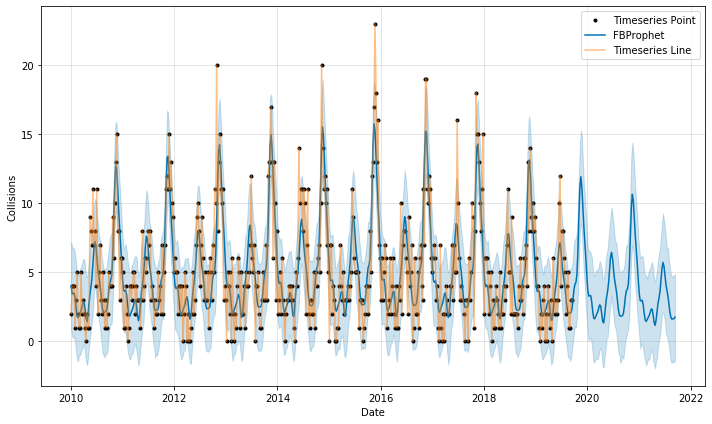

In [71]:
fig1 = weekly_prophet.plot(weekly_forecast, xlabel='Date', ylabel='Collisions')
x = weekly_full.ds
y = weekly_full.y
plt.plot(x, y, color='C1', alpha=.5)
plt.legend(['Timeseries Point', 'FBProphet', 'Timeseries Line'])
#plt.ylim(0, 120)
None

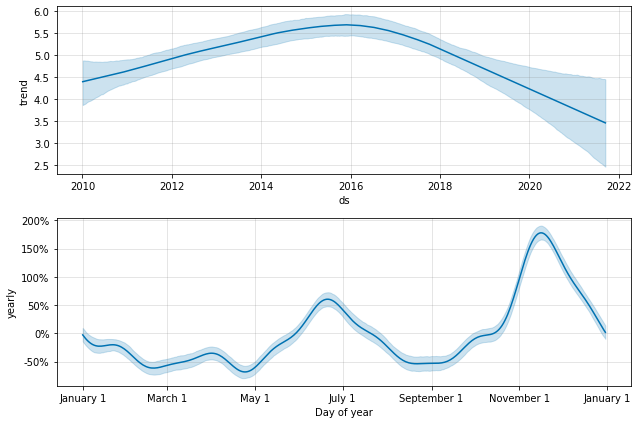

In [81]:
fig2 = weekly_prophet.plot_components(weekly_forecast)
#plt.savefig('prophet.svg')

In [84]:
type(weekly_prophet)

fbprophet.forecaster.Prophet

In [87]:
weekly_prophet.params.keys()

dict_keys(['k', 'm', 'delta', 'sigma_obs', 'beta'])

In [134]:
weekly_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-03,4.394746,0.800684,7.177499,3.865117,4.875518,-0.084629,-0.200839,0.038903,-0.084629,-0.200839,0.038903,0.0,0.0,0.0,4.022821
1,2010-01-10,4.399447,0.370278,6.768509,3.875844,4.877205,-0.217076,-0.337306,-0.086078,-0.217076,-0.337306,-0.086078,0.0,0.0,0.0,3.444430
2,2010-01-17,4.404147,0.254540,6.793800,3.886117,4.875057,-0.217062,-0.324585,-0.101925,-0.217062,-0.324585,-0.101925,0.0,0.0,0.0,3.448172
3,2010-01-24,4.408847,0.334115,6.687594,3.896389,4.875119,-0.205868,-0.308476,-0.105682,-0.205868,-0.308476,-0.105682,0.0,0.0,0.0,3.501207
4,2010-01-31,4.413548,-0.057961,6.294755,3.910149,4.869992,-0.291353,-0.411967,-0.175300,-0.291353,-0.411967,-0.175300,0.0,0.0,0.0,3.127649


In [150]:
start = pd.Timestamp(year=2019, month=12, day=31)
end = pd.Timestamp(year=2021, month=1, day=1)

In [151]:
test = weekly_forecast.copy()['yearly']
test.index = weekly_forecast.ds

In [152]:
subtest = test[start:end]

In [220]:
dt = pd.to_datetime('2019-10-20')

In [221]:
dt

Timestamp('2019-10-20 00:00:00')

In [222]:
test.index.get_loc(dt, method='nearest')

511

In [223]:
idx = test.index.get_loc(dt, method='nearest')
date_prob = test.iloc[idx]

In [224]:
date_prob

0.3256462018005471

In [225]:
date_prob*time_prob

0.24759793476235734

In [162]:
test -= test.min()
test /= test.max()

In [168]:
test.to_csv('prophet_models/yearly_trend_2010_2022.csv', header=True)

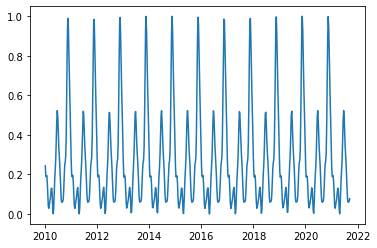

In [163]:
plt.plot(test)

Time to pull components. See [here](https://stackoverflow.com/questions/47534553/how-to-extract-seasonal-trends-from-prophet).

Saving the model is detailed [here](https://github.com/facebook/prophet/issues/725). That might be good enough for me. I could upload the model and make a prediction just based on components.

In [88]:
import pickle
pkl_path = "prophet_models/vt_yearly_prophet_model_190919.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

# save the dataframe
forecast.to_pickle("prophet_models/vt_yearly_prophet_forecast_190919.pkl")
print("*** Data Saved ***")

*** Data Saved ***


In [77]:
weekly_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-03,4.394746,0.800684,7.177499,3.865117,4.875518,-0.084629,-0.200839,0.038903,-0.084629,-0.200839,0.038903,0.0,0.0,0.0,4.022821
1,2010-01-10,4.399447,0.370278,6.768509,3.875844,4.877205,-0.217076,-0.337306,-0.086078,-0.217076,-0.337306,-0.086078,0.0,0.0,0.0,3.444430
2,2010-01-17,4.404147,0.254540,6.793800,3.886117,4.875057,-0.217062,-0.324585,-0.101925,-0.217062,-0.324585,-0.101925,0.0,0.0,0.0,3.448172
3,2010-01-24,4.408847,0.334115,6.687594,3.896389,4.875119,-0.205868,-0.308476,-0.105682,-0.205868,-0.308476,-0.105682,0.0,0.0,0.0,3.501207
4,2010-01-31,4.413548,-0.057961,6.294755,3.910149,4.869992,-0.291353,-0.411967,-0.175300,-0.291353,-0.411967,-0.175300,0.0,0.0,0.0,3.127649


In [79]:
weekly_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
606,2021-08-15,3.495060,-1.526252,4.838173,2.533480,4.459626,-0.513143,-0.641326,-0.384271,-0.513143,-0.641326,-0.384271,0.0,0.0,0.0,1.701596
607,2021-08-22,3.486370,-1.537857,4.697079,2.515489,4.454744,-0.538698,-0.666706,-0.412109,-0.538698,-0.666706,-0.412109,0.0,0.0,0.0,1.608268
608,2021-08-29,3.477681,-1.402401,4.743425,2.499318,4.457149,-0.532265,-0.658930,-0.404159,-0.532265,-0.658930,-0.404159,0.0,0.0,0.0,1.626634
609,2021-09-05,3.468992,-1.540182,4.624002,2.481449,4.456058,-0.530091,-0.653615,-0.403290,-0.530091,-0.653615,-0.403290,0.0,0.0,0.0,1.630112
610,2021-09-12,3.460302,-1.364490,4.904657,2.466531,4.448674,-0.494318,-0.604799,-0.380615,-0.494318,-0.604799,-0.380615,0.0,0.0,0.0,1.749812


In [78]:
weekly_forecast.shape

(611, 16)

### Group collisions by month

In [42]:
test = df.copy()
test.index = test["Crash Date"]
monthly_full = test.groupby(pd.Grouper(freq='M')).count().ObjectID
monthly_full = monthly_full.reset_index()
monthly_full.columns = ['ds', 'y']

In [43]:
monthly_prophet = Prophet(seasonality_mode='multiplicative', mcmc_samples=300)
monthly_prophet.fit(monthly_full)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
monthly_future = monthly_prophet.make_future_dataframe(periods=36, freq='M')
monthly_forecast = monthly_prophet.predict(monthly_future)

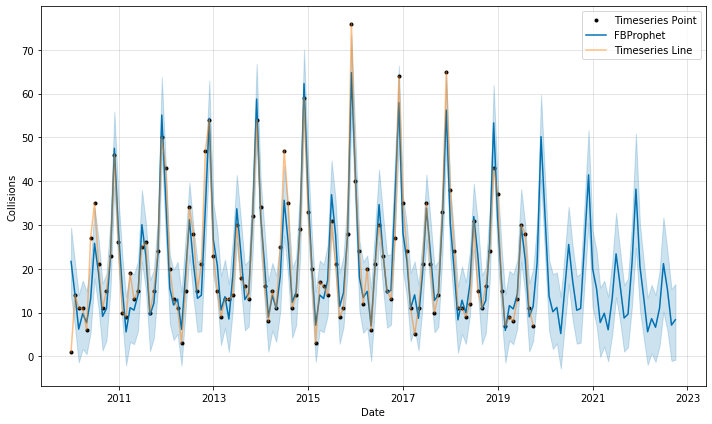

In [50]:
fig1 = monthly_prophet.plot(monthly_forecast, xlabel='Date', ylabel='Collisions')
x = monthly_full.ds
y = monthly_full.y
plt.plot(x, y, color='C1', alpha=.5)
plt.legend(['Timeseries Point', 'FBProphet', 'Timeseries Line'])
#plt.ylim(0, 120)
None

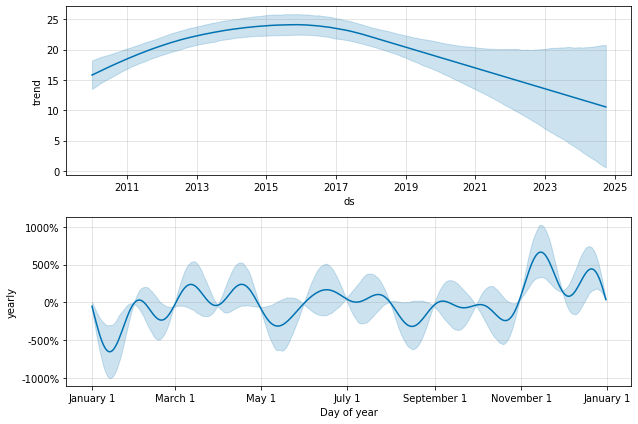

In [51]:
fig2 = monthly_prophet.plot_components(forecast)

# Errata

In [22]:
timeseries = test.groupby(pd.Grouper(freq='M')).count().ObjectID
timeseries = timeseries.reset_index()
timeseries.columns = ['ds', 'y']

In [41]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300)
m.fit(monthly_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Process ForkPoolWorker-30:
Process ForkPoolWorker-32:
Process ForkPoolWorker-31:
Process ForkPoolWorker-35:
Process ForkPoolWorker-29:
Process ForkPoolWorker-34:
Process ForkPoolWorker-36:
Process ForkPoolWorker-33:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/

KeyboardInterrupt: 

  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-45:
Pro

In [ ]:
years = 1
future = m.make_future_dataframe(periods=60, freq='M')
#future.tail()

In [ ]:
forecast = m.predict(future)

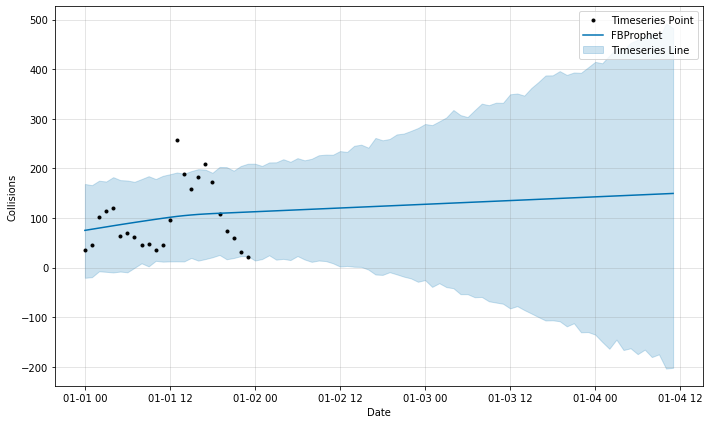

In [26]:
fig1 = m.plot(forecast, xlabel='Date', ylabel='Collisions')
x = pd.to_datetime(timeseries.ds)
y = timeseries.y
#plt.plot(x, y, color='C1', alpha=.25)
plt.legend(['Timeseries Point', 'FBProphet', 'Timeseries Line'])
#plt.ylim(0, 120)
None

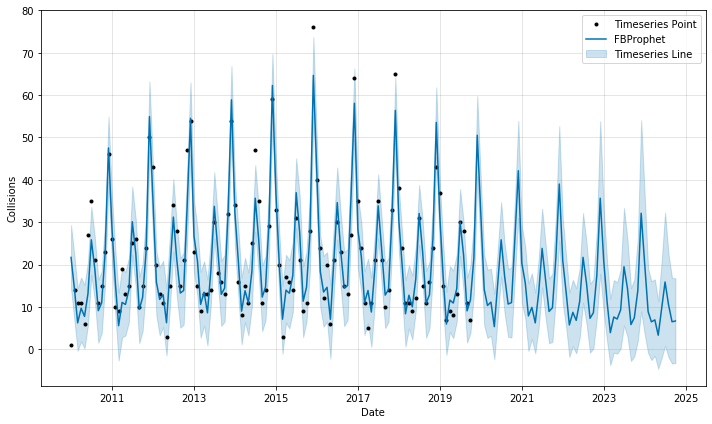

In [38]:
fig1 = m.plot(forecast, xlabel='Date', ylabel='Collisions')
x = pd.to_datetime(timeseries.ds)
y = timeseries.y
#plt.plot(x, y, color='C1', alpha=.25)
plt.legend(['Timeseries Point', 'FBProphet', 'Timeseries Line'])
#plt.ylim(0, 120)
None

In [ ]:
fig1 = m.plot(forecast, xlabel='Date', ylabel='Collisions')
x = pd.to_datetime(timeseries.ds)
y = timeseries.y
plt.plot(x, y, color='C1', alpha=.25)
plt.legend(['Timeseries Point', 'FBProphet', 'Timeseries Line'])
#plt.ylim(0, 120)
None

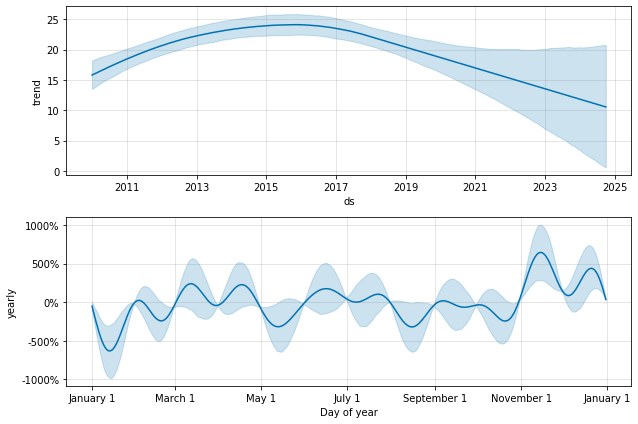

In [39]:
fig2 = m.plot_components(forecast)